# **Please use cellrank list of required package versions**

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import math
import seaborn as sns
import os
# %config IPCompleter.greedy=True
%load_ext autoreload
%autoreload 2

sc.settings.verbosity = 0
sc.logging.print_header()
sns.set_context("paper")

scanpy==1.9.1 anndata==0.7.6 umap==0.5.1 numpy==1.20.3 scipy==1.7.1 pandas==1.3.3 scikit-learn==1.0 statsmodels==0.13.0rc0 pynndescent==0.5.4


In [2]:
# import local module containing misc code, helps keep notebooks clean from commonly used functions
import new_misc_code as nmc 

In [3]:
import scvelo as scv
scv.logging.print_version()

Running scvelo 0.2.4 (python 3.7.6) on 2022-08-16 14:45.


ERROR: XMLRPC request failed [code: -32500]
RuntimeError: PyPI's XMLRPC API is currently disabled due to unmanageable load and will be deprecated in the near future. See https://status.python.org/ for more information.


## Using scanpy concatenate loom files

In [4]:
# concatenate list of loom files into one anndata
# will all looms within supplied directory
def loom_concat_into_anndata( path_to_looms):
    # list of loom files
    loom_file_list = np.array( os.listdir( path_to_looms))
    # read in h5 files and concat to single anndata object
    for itr, fl_itr in enumerate( loom_file_list):
        # get batch id from file naming, assumes same convention as pre-mRNA data
        id_itr = ('_').join( fl_itr.split('_')[:3])
#         print( fl_itr)
        if( itr==0):
            ann_cat = scv.read( path_to_looms + fl_itr, cache=True)
            ann_cat.var_names_make_unique()
            num_nucs = [ann_cat.shape[0]]
            batch_ids = np.array( [id_itr]*ann_cat.shape[0])
        else:
            ann_itr = scv.read( path_to_looms + fl_itr, cache=True)
            ann_itr.var_names_make_unique()
            num_nucs.append( ann_itr.shape[0])
            batch_ids = np.append( batch_ids, [id_itr]*ann_itr.shape[0])
            ann_cat = sc.AnnData.concatenate( ann_cat, ann_itr, join='inner', batch_categories=None)
    ann_cat.obs['batch'] = batch_ids
    # reformat barcodes to include seq and sample id to deal with barcode clashes
    BCs = np.array( [ii.split('-')[0] + '-' + jj for ii, jj in zip( ann_cat.obs_names.values, ann_cat.obs['batch'])])
    BCs = np.array( [ii.split(":")[1].replace("x","") for ii in BCs], dtype=object)
    ann_cat.obs_names = BCs
    return( ann_cat)

In [5]:
path_to_looms = "/dd_userdata/usrdat03/userdata/cherring/data/cellranger_outputs/brain_maturation_RNA/velocity_mappings/loom_files/"

In [6]:
looms_adata = loom_concat_into_anndata( path_to_looms)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Vari

In [7]:
looms_adata

AnnData object with n_obs × n_vars = 150989 × 32738
    obs: 'Clusters', '_X', '_Y', 'batch'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [8]:
# obs naming format matches pre-mRNA data format
looms_adata.obs_names

Index(['AAAGTAGCAGACGCCT-RL1612_34d_v2', 'AAAGCAATCTAACTCT-RL1612_34d_v2',
       'AAAGATGGTGCGAAAC-RL1612_34d_v2', 'AAATGCCCAGTCAGCC-RL1612_34d_v2',
       'AAAGCAACAAGGTTCT-RL1612_34d_v2', 'AACACGTTCTGCAGTA-RL1612_34d_v2',
       'AAAGCAAAGCACGCCT-RL1612_34d_v2', 'AAACGGGCATCCGGGT-RL1612_34d_v2',
       'AAAGATGTCTTGCCGT-RL1612_34d_v2', 'AAAGCAAGTCTCATCC-RL1612_34d_v2',
       ...
       'TTTACTGGTTCTCACC-RL2105_627d_v3', 'TTTCATGGTTACGTAC-RL2105_627d_v3',
       'TTTCACATCAGTGCGC-RL2105_627d_v3', 'TTTGGAGCAGACCTGC-RL2105_627d_v3',
       'TTTGGTTTCTAGTACG-RL2105_627d_v3', 'TTTGATCTCCGTGACG-RL2105_627d_v3',
       'TTTCGATAGTCTGGTT-RL2105_627d_v3', 'TTTAGTCAGGTACCTT-RL2105_627d_v3',
       'TTTACCACACAAAGTA-RL2105_627d_v3', 'TTGTTCATCTAGTGTG-RL2105_627d_v3'],
      dtype='object', length=150989)

In [9]:
# save incase shit gets weird 
looms_file_nm = "../data/2020-09-09_concated-looms.h5ad"
looms_adata.write( looms_file_nm)

... storing 'batch' as categorical


## Add spliced and unspliced matrices to pre-mRNA data

In [10]:
# load pre-mRNA data 
in_file_nm = "../data/post-gaba-wt-dev-traj.h5ad"
pre_adata = sc.read( in_file_nm)

Note: pre-mRNA data has already been downsampled and pre-processed, so it is currently in logged form 

In [11]:
# adatas do not contain same nucs, so need to take intersect of barcodes (BCs) 
all_loom_mk  = nmc.member_test( looms_adata.obs_names.values, pre_adata.obs_names.values)
pre_adata_mk = nmc.member_test( pre_adata.obs_names.values,  looms_adata.obs_names.values)
loom = looms_adata[all_loom_mk]
adata = pre_adata[pre_adata_mk]
loom.shape, adata.shape

((132229, 32738), (132229, 26747))

In [12]:
# check if order of BCs match, should sum to 0; they don't
(adata.obs_names.values!=loom.obs_names.values).sum()

131698

In [13]:
# need to match order of BCs to make sure (un)spliced cts get assigned to correct nucs
# ## this takes about 2min to run ##
loom_bc_list = loom.obs_names.values.tolist()
pre_bc_list  = adata.obs_names.values.tolist()
# return adata args in loom BC order 
pre_to_loom_args = np.array([pre_bc_list.index(ii) for ii in loom_bc_list])
adata = adata[pre_to_loom_args]

In [14]:
# just to know in our hearts the orders now match
(adata.obs_names.values!=loom.obs_names.values).sum()

0

In [15]:
# repeat process with genes
all_loom_gene_mk  = nmc.member_test( loom.var_names.values, adata.var_names.values)
pre_adata_gene_mk = nmc.member_test( adata.var_names.values,  loom.var_names.values)
loom  = loom[:,all_loom_gene_mk]
adata = adata[:,pre_adata_gene_mk]
loom.shape, adata.shape

((132229, 26747), (132229, 26747))

In [16]:
# need to match order of BCs to make sure (un)spliced cts get assigned to correct nucs
# ## this takes about 2min to run ##
loom_gene_list = loom.var_names.values.tolist()
pre_gene_list  = adata.var_names.values.tolist()
# return adata args in loom BC order 
pre_to_loom_gene_args = np.array([pre_gene_list.index(ii) for ii in loom_gene_list])
adata = adata[:,pre_to_loom_gene_args]

In [17]:
# check gene order match
(adata.var_names.values!=loom.var_names.values).sum()

0

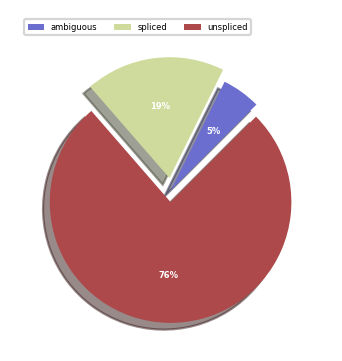

In [18]:
# summary view of layers
scv.pl.proportions( loom, layers=['ambiguous','spliced','unspliced'], fontsize=3, dpi=200)

In [19]:
# set loom layers to adata, do not need ambiguous counts
adata.layers['spliced']   = loom.layers['spliced']
adata.layers['unspliced'] = loom.layers['unspliced']
adata.layers['matrix'] = loom.layers['matrix']

## Save anndata

In [20]:
out_file_nm = "../data/whole-tissue_with-looms.h5ad"
adata.write( out_file_nm)